In [1]:
# Импортируйте библиотеку для кодирования в Base64
import base64

# Создайте функцию, которая кодирует файл и возвращает результат.
def encode_file(file):
  file_content = file.read()
  return base64.b64encode(file_content)

In [18]:
import base64
import json
import requests

def encode_file(file_path):
    """Encode file in base64 format."""
    with open(file_path, "rb") as file:
        file_content = file.read()
    return base64.b64encode(file_content).decode('utf-8')

def create_request_body(image_base64, mime_type="image/jpeg"):
    """Create the request body for the OCR API."""
    body = {
        "mimeType": mime_type,
        "languageCodes": ["*"],
        "model": "page",
        "content": image_base64
    }
    return body

def recognize_text(image_path, iam_token, folder_id, mime_type="image/jpeg"):
    """Recognize text from an image using Yandex OCR API."""
    # Encode the image file
    image_base64 = encode_file(image_path)

    # Create request body
    body = create_request_body(image_base64, mime_type)

    # Set headers
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {iam_token}",
        "x-folder-id": folder_id,
        "x-data-logging-enabled": "true"
    }

    # Send POST request to the OCR API
    response = requests.post(
        "https://ocr.api.cloud.yandex.net/ocr/v1/recognizeText",
        headers=headers,
        data=json.dumps(body)
    )

    # Save the response to output.json
    with open("output.json", "w", encoding='utf-8') as output_file:
        json.dump(response.json(), output_file, ensure_ascii=False, indent=4)

    return response.json()

# Example usage
iam_token = "t1.9euelZqPmM6YkJWViorNi8-WyJmMzu3rnpWax87Mx5qQls-Sj5Cbl4uLz8rl8_dGXzlL-e9HPBF0_t3z9wYON0v570c8EXT-zef1656Vmp2Rzp2UlZuJyc6WloqXismT7_zF656Vmp2Rzp2UlZuJyc6WloqXismT.Ha6rr5sl8h090-MmwJB48RahBELj0pWFz9-ftzfFmm5M3APxz4gkM1FkHhC7mU071Bt_rhW7A0HjRyh13sVEAQ"  # Replace with your IAM token
folder_id = "b1gq29l21hnprus23qir"  # Replace with your folder ID

# Путь должен быть по английски написан!
image_path = "img.jpg"  # Replace with the path to your image

result = recognize_text(image_path, iam_token, folder_id)
# print(json.dumps(result, ensure_ascii=False, indent=4))


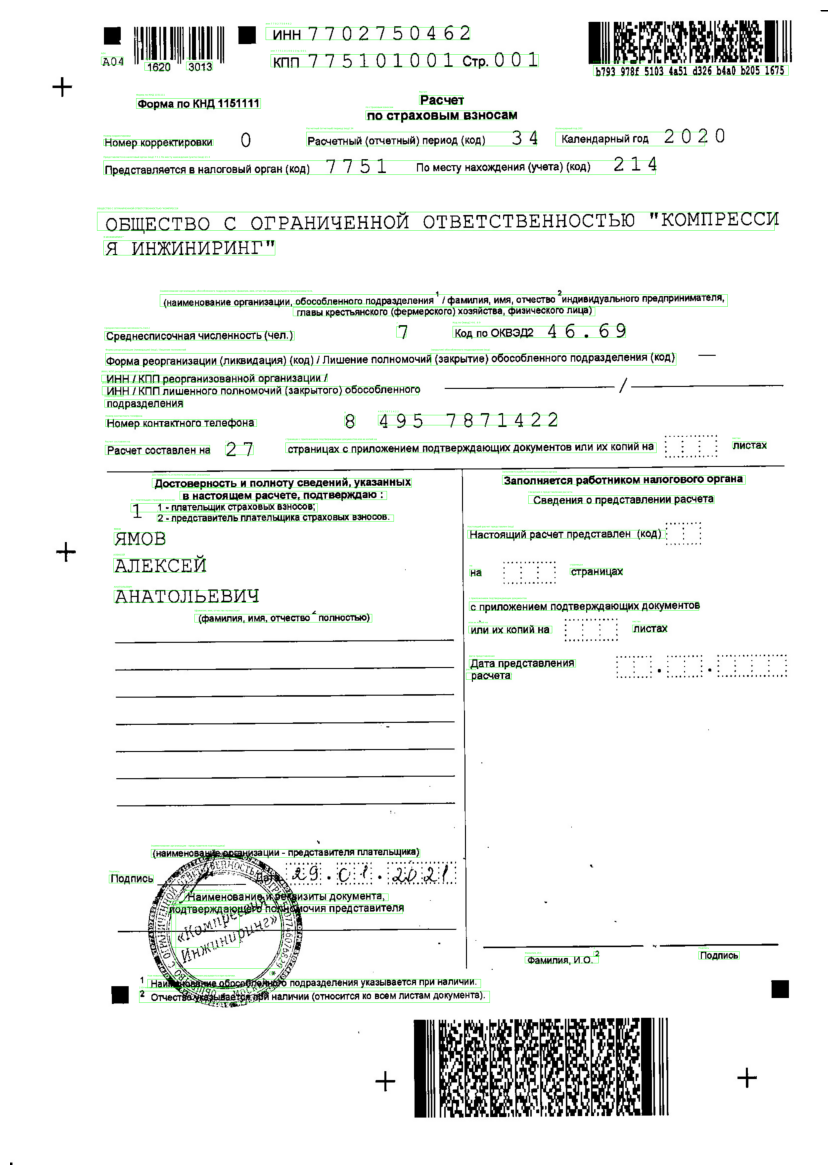

In [19]:
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

def draw_bounding_boxes_from_result(image_path, output_path, result, scale_factor=3):
    # Read the image
    image = cv2.imread(image_path)

    # Resize the image
    width = int(image.shape[1] * scale_factor)
    height = int(image.shape[0] * scale_factor)
    resized_image = cv2.resize(image, (width, height))

    # Convert OpenCV image (BGR) to PIL image (RGB)
    pil_image = Image.fromarray(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(pil_image)

    font_size = 14
    # Load the default PIL font
    font = ImageFont.truetype("fonts//DejaVuSans.ttf", font_size)

    # Parse the dictionary result and draw the bounding boxes and text
    for block in result['result']['textAnnotation']['blocks']:
        for line in block['lines']:
            vertices = line['boundingBox']['vertices']
            top_left = (int(vertices[0]['x']) * scale_factor, int(vertices[0]['y']) * scale_factor)
            top_right = (int(vertices[1]['x']) * scale_factor, int(vertices[1]['y']) * scale_factor)
            bottom_right = (int(vertices[2]['x']) * scale_factor, int(vertices[2]['y']) * scale_factor)
            bottom_left = (int(vertices[3]['x']) * scale_factor, int(vertices[3]['y']) * scale_factor)

            # Draw the bounding box
            draw.line([top_left, top_right, bottom_right, bottom_left, top_left], fill=(0, 255, 0), width=2)

            # Put the OCR text on the image
            draw.text((top_left[0], top_left[1] - 30), line['text'], fill=(0, 255, 0), font=font)

    # Convert PIL image back to OpenCV image
    final_image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

    # Save the result image
    cv2.imwrite(output_path, final_image)

    # Convert BGR image to RGB for displaying with matplotlib
    final_image_rgb = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(15, 15))
    plt.imshow(final_image_rgb)
    plt.axis('off')
    plt.show()


# image_path = "img.jpg"
output_path = 'output_image_with_boxes.jpg'

# Используем существующую переменную result
draw_bounding_boxes_from_result(image_path, output_path, result)
